<a href="https://colab.research.google.com/github/GalynaDe/ML/blob/main/HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [10]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Area under ROC score on Train dataset: 0.77%


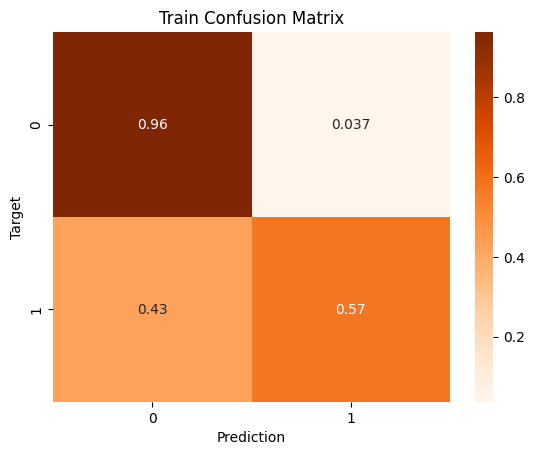

Area under ROC score on Validation dataset: 0.76%


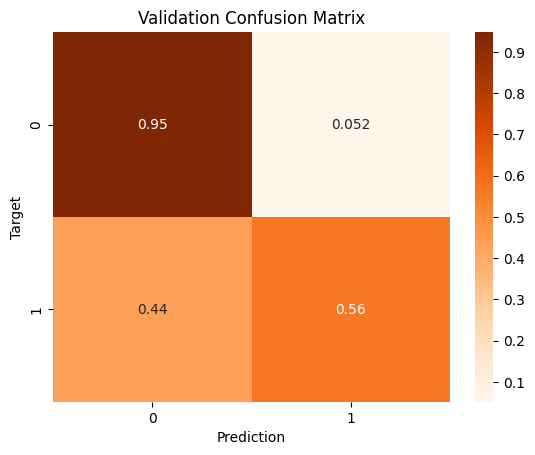

['logregress_model.joblib']

In [17]:
raw_df =pd.read_csv("drive/MyDrive/ML course 2024/HW 2.2/train.csv")

train_df, val_df = train_test_split(raw_df.drop(columns=['CustomerId']), test_size=0.2, random_state=42, stratify=raw_df['Exited'])
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that includes preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model_pipeline.fit(train_inputs, train_targets)

# Helper function to predict, compute accuracy & plot confusion matrix
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Oranges')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Evaluate on train and val set
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Save the trained model
joblib.dump(model_pipeline, 'logregress_model.joblib')




In [18]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Surname', 'Geography',
                                                   'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.
  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [19]:
from sklearn.preprocessing import PolynomialFeatures

Area under ROC score on Train dataset: 0.80%


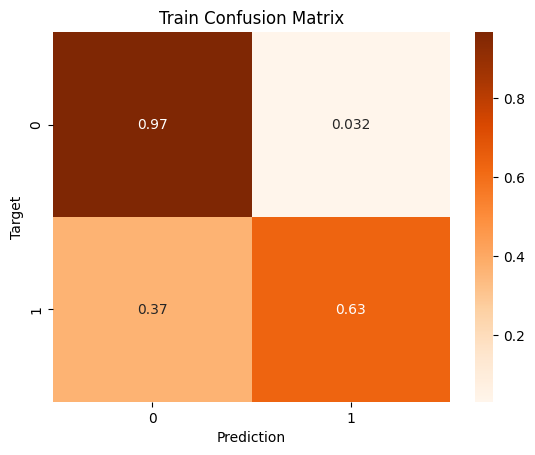

Area under ROC score on Validation dataset: 0.79%


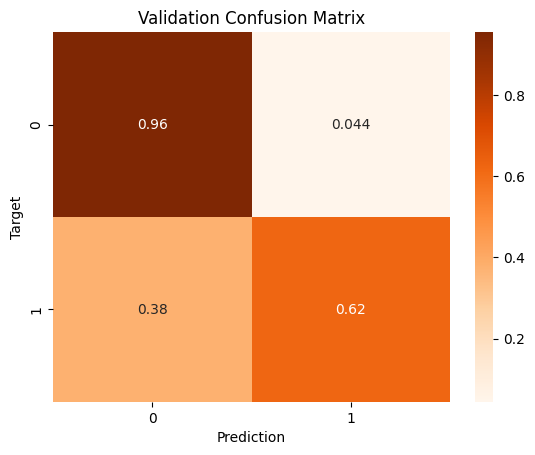

['logregress_model_pf.joblib']

In [20]:
numeric_transformer_pf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=2))
])

preprocessor_pf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_pf, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline_pf = Pipeline(steps=[
    ('preprocessor', preprocessor_pf),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model_pipeline_pf.fit(train_inputs, train_targets)

# Evaluate on train and val set
train_preds = predict_and_plot(model_pipeline_pf, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline_pf, val_inputs, val_targets, 'Validation')

# Save the trained model
joblib.dump(model_pipeline, 'logregress_model_pf.joblib')

In [21]:
model_pipeline_pf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly_features',
                                                                   PolynomialFeatures())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Surname', 'Geography',
                                                   'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.83%


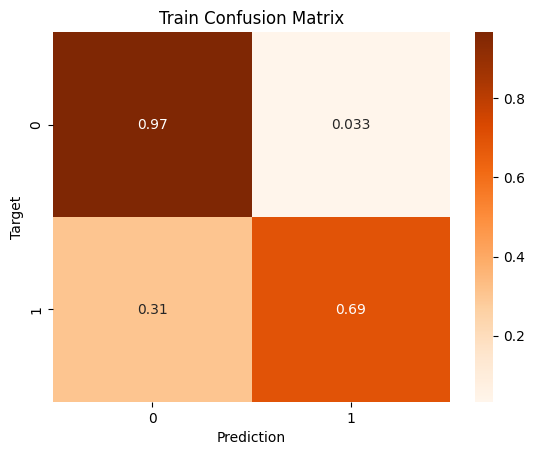

Area under ROC score on Validation dataset: 0.81%


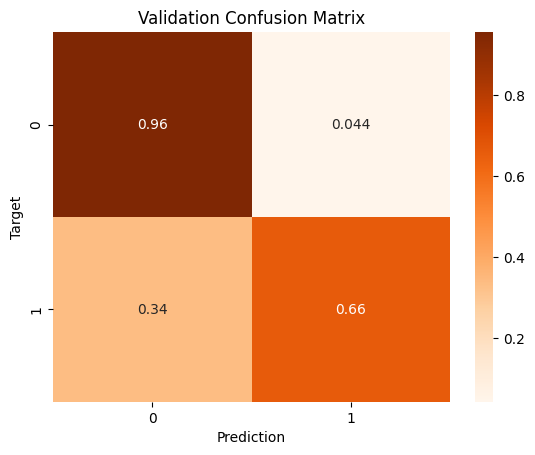

['logregress_model_pf4.joblib']

In [22]:
numeric_transformer_pf_4 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=4))
])

preprocessor_pf_4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_pf_4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline_pf_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_pf_4),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model_pipeline_pf_4.fit(train_inputs, train_targets)

# Evaluate on train and val set
train_preds = predict_and_plot(model_pipeline_pf_4, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline_pf_4, val_inputs, val_targets, 'Validation')

# Save the trained model
joblib.dump(model_pipeline, 'logregress_model_pf4.joblib')

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [24]:
df =pd.read_csv("drive/MyDrive/ML course 2024/HW 2.2/regression_data.csv")

In [25]:
df

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013
...,...,...,...,...,...,...
124,1.402794,0.586857,-1.401851,0.791032,-0.909387,39.626185
125,-0.288659,-0.827231,0.322719,-1.002529,-0.018513,-50.585687
126,-1.407464,-0.213447,-0.718444,0.232050,-1.448084,13.719861
127,1.353872,1.237816,-0.114540,-0.469176,-1.713135,-23.851350


In [26]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
input_cols = list(train_df.columns)[1:-1]
target_col = 'target'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np

def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)

    train_rmse = np.sqrt(train_mse).round(6)
    val_rmse = np.sqrt(val_mse).round(6)

    return dict(train=train_rmse, val=val_rmse)

model = LinearRegression()
numeric_transformer_new_data = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=5))
])

model_pipeline_new_data = Pipeline(steps=[
    ('preprocessor', numeric_transformer_new_data),
    ('classifier', model)
])

# Train the model (при умові, що train_inputs та train_targets вже визначено)
model_pipeline_new_data.fit(train_inputs, train_targets)

# Evaluate the model (при умові, що val_inputs та val_targets вже визначено)
eval_results  = evaluate_model(model_pipeline_new_data, train_inputs, train_targets, val_inputs, val_targets)
print(f'{str(model)}: {eval_results}\n')


LinearRegression(): {'train': 0.0, 'val': 90.19667}



Модель правильно передбачає на тренувальних даних, а ось на валідаційних сильно помиляється. Треба використовувати регуляризацію.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [29]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [30]:
models = [
    Ridge(),
    Lasso(),
    ElasticNet(),
]

for model in models:
  numeric_transformer_new_data = Pipeline(steps=[
      ('scaler', MinMaxScaler()),
      ('poly_features', PolynomialFeatures(degree=20))
  ])

  model_pipeline_new_data = Pipeline(steps=[
      ('preprocessor', numeric_transformer_new_data),
      ('regressor', model)
  ])

  # Train the model
  model_pipeline_new_data.fit(train_inputs, train_targets)

  eval_results  = evaluate_model(model_pipeline_new_data, train_inputs, train_targets, val_inputs, val_targets)
  print(f'{str(model)}: {eval_results}\n')

Ridge(): {'train': 6.716122, 'val': 8.398202}

Lasso(): {'train': 5.098171, 'val': 5.671931}

ElasticNet(): {'train': 32.029775, 'val': 33.313501}



In [31]:
df.corr()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
feature_1,1.000000,0.090286,0.068160,0.005709,0.112917,0.007453
feature_2,0.090286,1.000000,-0.031918,-0.050098,0.075303,-0.049995
feature_3,0.068160,-0.031918,1.000000,-0.043707,0.016758,-0.042851
feature_4,0.005709,-0.050098,-0.043707,1.000000,-0.151899,0.999734
feature_5,0.112917,0.075303,0.016758,-0.151899,1.000000,-0.155143
target,0.007453,-0.049995,-0.042851,0.999734,-0.155143,1.000000


 Mодель Lasso показує найкращий результат.